In [1]:
# Install and setup dependencies
# First cell is necessary to disable the cache in JAX-COSMO
import os

os.environ["JC_CACHE"] = "off"
os.environ["JAX_PLATFORM_NAME"] = "cpu"

# Uncomment if jax_cosmo needs to be installed/updated
# !pip install --quiet git+https://github.com/ASKabalan/jax_cosmo &> /dev/null

# Flat-Sky Ray Tracing: Simulation vs Theory Comparison

This notebook demonstrates how to:
1. Run flat-sky ray tracing simulations for different mesh resolutions  
2. Compute angular power spectra from convergence maps using JaxPM's native implementation
3. Compare simulation results with theoretical predictions
4. Analyze convergence behavior with increasing resolution

**Key Features:**
- Single source redshift analysis using delta function
- Multi-resolution comparison  
- Flat-sky geometry with proper coordinate handling
- Theoretical validation using jax_cosmo
- Native JaxPM power spectrum computation
- Beautiful comparison plots

**Key Differences from Spherical Case:**
- Observer at origin instead of box center
- Flat-sky convergence maps instead of HEALPix
- Uses `jaxpm.utils.flat_sky_power_spectrum` for analysis
- Cartesian coordinate system for ray tracing

In [2]:
from functools import partial
from typing import Any, NamedTuple

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import jax_cosmo.constants as constants
from diffrax import (
    ODETerm,
    RecursiveCheckpointAdjoint,
    SaveAt,
    diffeqsolve,
    SemiImplicitEuler,
    ConstantStepSize,
)
from jax.scipy.ndimage import map_coordinates
from jax_cosmo.scipy.integrate import simps
from jaxpm.distributed import fft3d, ifft3d, normal_field, uniform_particles
from jaxpm.kernels import fftk
from jaxpm.painting import cic_paint_2d, cic_paint_dx
from jaxpm.pm import (
    growth_factor,
    growth_rate,
    pm_forces,
    linear_field,
    lpt,
    make_diffrax_ode,
)
from jaxpm.growth import E
from jaxpm.utils import gaussian_smoothing
from jaxpm.ode import symplectic_ode
from jaxpm.lensing import density_plane_fn, convergence_Born
from jaxpm.utils import flat_sky_power_spectrum
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

print("All imports successful!")

All imports successful!


In [3]:
jax.config.update("jax_enable_x64", False)

# Flat Sky Projection

   ## 1. Setup and Cosmology
   
   First, we import necessary libraries and define our cosmological model. We use `jax_cosmo` for cosmological calculations and `diffrax` for solving the N-body ODE.

In [4]:
Planck18 = partial(
    jc.Cosmology,
    # Omega_m = 0.3111
    Omega_c=0.2607,
    Omega_b=0.0490,
    Omega_k=0.0,
    h=0.6766,
    n_s=0.9665,
    sigma8=0.8102,
    w0=-1.0,
    wa=0.0,
)

cosmo = Planck18()

print(f"âœ“ Cosmology:")
print(f"  H0 = {cosmo.h * 100:.1f} km/s/Mpc")
print(f"  Î©m = {cosmo.Omega_c + cosmo.Omega_b:.4f}")
print(f"  Ïƒ8 = {cosmo.sigma8:.4f}")

âœ“ Cosmology:
  H0 = 67.7 km/s/Mpc
  Î©m = 0.3097
  Ïƒ8 = 0.8102


## 2. Simulation Parameters
  
Here, we define the key parameters for our N-body simulation and ray tracing. These include the mesh shape, box size, and properties related to the density planes and lensing fields.


In [5]:
# =============================================================================
# CONTROL PARAMETERS - Modify these for your analysis
# =============================================================================

# Source redshift for lensing analysis
z_source = 0.2

# Mesh sizes to test (start small for laptop, increase for production)
mesh_sizes = [128, 256]  # Add 256 if you have enough memory/time

# Flat-sky field parameters
field_size = 9.6  # degrees
field_npix = 128  # Match mesh_shape[0] for simplicity

# Simulation parameters
density_plane_width = 100.0  # Width of density slices in Mpc/h
density_plane_npix = 128  # Resolution of density planes
density_plane_smoothing = 0.1  # Set to 0 to disable smoothing
min_redshift = 0.0

# Time integration parameters
t0, t1 = 0.1, 1.0  # Scale factor range
dt0 = 0.05  # Initial timestep

# Random seed for reproducibility
seed = 42

print(f"âœ“ Analysis setup:")
print(f"  Source redshift: z = {z_source}")
print(f"  Mesh sizes: {mesh_sizes}")
print(f"  Field size: {field_size}Â° with {field_npix}x{field_npix} pixels")
print(f"  Density plane resolution: {density_plane_npix}x{density_plane_npix}")

âœ“ Analysis setup:
  Source redshift: z = 0.2
  Mesh sizes: [128, 256]
  Field size: 9.6Â° with 128x128 pixels
  Density plane resolution: 128x128


## Box Size Calculation

For full-sky analysis, we place the observer at the center of the simulation box.
The box size is determined by the comoving distance to the source redshift.

In [ ]:
# Compute comoving distance to source redshift
r_comoving = (
    jc.background.radial_comoving_distance(cosmo, jc.utils.z2a(z_source)) / cosmo.h
)
r_scalar = float(r_comoving.squeeze())

# Box size: comoving distance (observer at one edge, not center for flat-sky)
box_size = (r_scalar,) * 3

print(f"âœ“ Geometry:")
print(f"  Comoving distance to z={z_source}: {r_scalar:.1f} Mpc/h")
print(f"  Box size: {box_size[0]:.1f} Mpc/h per side")
print(f"  Observer position: origin (flat-sky geometry)")
print(f"  Volume: {(box_size[0] / 1000) ** 3:.2f} (Gpc/h)Â³")
print(f"  Shell thickness: {density_plane_width} Mpc/h")

âœ“ Geometry:
  Comoving distance to z=0.2: 844.2 Mpc/h
  Box size: 844.2 Mpc/h per side
  Observer position: origin (flat-sky geometry)
  Volume: 0.60 (Gpc/h)Â³
  Shell thickness: 100.0 Mpc/h


/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


## 4. Running the N-body Simulation

This section sets up and runs the N-body simulation.
-   We generate initial conditions based on a linear matter power spectrum.
-   Particles are displaced using LPT.
-   The simulation is evolved using a symplectic ODE solver from `diffrax`.
-   During the simulation, density planes are extracted at specific scale factors (redshifts) using the `density_plane_fn`.



In [ ]:
def run_lensing_simulation(
    mesh_size,
    cosmo,
    box_size,
    field_size,
    field_npix,
    density_plane_width,
    density_plane_npix,
    z_source,
    t0,
    t1,
    dt0,
    seed,
):
    """
    Run a complete flat-sky lensing simulation for a given mesh size.

    Parameters:
    -----------
    mesh_size : int
        Size of the mesh (mesh_sizeÂ³)
    cosmo : Cosmology
        Cosmological model
    box_size : tuple
        Physical size of the simulation box
    field_size : float
        Angular size of the field in degrees
    field_npix : int
        Number of pixels in the output convergence map
    density_plane_width : float
        Width of each density plane in Mpc/h
    density_plane_npix : int
        Resolution of density planes
    z_source : float
        Source redshift
    t0, t1 : float
        Initial and final scale factors
    dt0 : float
        Initial timestep
    seed : int
        Random seed

    Returns:
    --------
    convergence_map : array
        Flat-sky convergence map
    density_planes : array
        Density planes from the simulation
    """
    print(f"\n{'=' * 60}")
    print(f"Running flat-sky simulation: {mesh_size}Â³ mesh")
    print(f"{'=' * 60}")

    mesh_shape = (mesh_size, mesh_size, mesh_size)

    # 1. Create initial conditions
    print("1. Generating initial conditions...")
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmo, k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    initial_conditions = linear_field(
        mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(seed)
    )
    print(
        f"   Î´ statistics: mean={float(jnp.mean(initial_conditions)):.2e}, std={float(jnp.std(initial_conditions)):.3f}"
    )

    # 2. LPT displacements
    print("2. Computing LPT displacements...")
    dx, p, f = lpt(cosmo, initial_conditions, particles=None, a=t0, order=1)

    # 3. Setup time evolution
    print("3. Setting up time evolution...")
    drift, kick = symplectic_ode(mesh_shape, paint_absolute_pos=False)
    ode_fn = ODETerm(kick), ODETerm(drift)
    solver = SemiImplicitEuler()

    # 4. Define density planes
    print("4. Defining density planes...")
    n_lens = int(box_size[-1] // density_plane_width)
    r = jnp.linspace(0.0, box_size[-1], n_lens + 1)
    r_center = 0.5 * (r[1:] + r[:-1])
    a_center = jc.background.a_of_chi(cosmo, r_center)
    print(
        f"   Redshift range: z = {float(1 / jnp.max(a_center) - 1):.3f} - {float(1 / jnp.min(a_center) - 1):.3f}"
    )

    saveat = SaveAt(
        ts=a_center[::-1],
        fn=lambda t, y, args: density_plane_fn(
            mesh_shape, box_size, density_plane_width, density_plane_npix, None
        )(t, y[1], args),
    )

    # 5. Run simulation
    print("5. Running N-body simulation...")
    res = diffeqsolve(
        ode_fn,
        solver,
        t0=t0,
        t1=t1,
        dt0=dt0,
        y0=(p, dx),
        args=cosmo,
        saveat=saveat,
        stepsize_controller=ConstantStepSize(),
    )

    density_planes = res.ys
    print(f"   Simulation completed: {len(density_planes)} density planes")

    # 6. Compute convergence map
    print("6. Computing flat-sky convergence map...")
    dx_pixel = box_size[0] / density_plane_npix

    # Fix the order: density_planes should be [n_planes, nx, ny]
    lightcone = density_planes[::-1]  # Reverse time ordering

    # Define coordinate grid for lensing map
    xgrid, ygrid = jnp.meshgrid(
        jnp.linspace(0, field_size, field_npix, endpoint=False),
        jnp.linspace(0, field_size, field_npix, endpoint=False),
    )
    coords = jnp.array((jnp.stack([xgrid, ygrid], axis=0)) * (jnp.pi / 180))  # deg->rad

    # Compute convergence using Born approximation
    convergence_map = convergence_Born(
        cosmo,
        lightcone,
        r_center,
        a_center,
        z_source,
        d_r=density_plane_width,
        dx=dx_pixel,
        coords=coords,
    )

    print(
        f"   Îº statistics: mean={float(jnp.mean(convergence_map)):.2e}, std={float(jnp.std(convergence_map)):.2e}"
    )
    print(f"âœ“ Flat-sky simulation complete for {mesh_size}Â³ mesh")

    return convergence_map, density_planes


print("âœ“ Flat-sky simulation functions defined")

âœ“ Flat-sky simulation functions defined


In [8]:
def compute_theory_cl(cosmo, ell, z_source):
    """
    Compute theoretical angular power spectrum for flat-sky case.

    Parameters:
    -----------
    cosmo : Cosmology
        Cosmological model
    ell : array
        Multipole moments
    z_source : float
        Source redshift

    Returns:
    --------
    cl_theory : array
        Theoretical power spectrum at given ell values
    """
    tracer = jc.probes.WeakLensing(
        [jc.redshift.delta_nz(z_source)],
        sigma_e=0.0,  # No shape noise
    )

    cl_theory = jc.angular_cl.angular_cl(cosmo=cosmo, ell=ell, probes=[tracer])

    return cl_theory[0]  # Return auto-correlation


print("âœ“ Theory computation functions defined")

âœ“ Theory computation functions defined


In [9]:
# =============================================================================
# MULTI-RESOLUTION ANALYSIS
# =============================================================================

print(f"Starting multi-resolution flat-sky analysis...")
print(f"Mesh sizes: {mesh_sizes}")
print(f"Estimated time: ~{len(mesh_sizes) * 2} minutes")

# Storage for results
results = {}

for i, mesh_size in enumerate(mesh_sizes):
    print(f"\n[{i + 1}/{len(mesh_sizes)}] Processing {mesh_size}Â³ mesh...")

    # Run simulation
    kappa, density_planes = run_lensing_simulation(
        mesh_size,
        cosmo,
        box_size,
        field_size,
        field_npix,
        density_plane_width,
        density_plane_npix,
        z_source,
        t0,
        t1,
        dt0,
        seed,
    )

    # Compute power spectrum using JaxPM's flat_sky_power_spectrum
    ell_range = (50, 1000)
    n_bins = 20
    ells = jnp.logspace(jnp.log10(ell_range[0]), jnp.log10(ell_range[1]), n_bins)

    ell, cl_sim = flat_sky_power_spectrum(kappa, angle_deg=field_size, ells=ells)

    # Store results
    results[mesh_size] = {
        "density_planes": density_planes,
        "kappa": kappa,
        "ell": ell,
        "cl_sim": cl_sim,
        "mesh_size": mesh_size,
    }

    print(
        f"âœ“ {mesh_size}Â³ complete: {len(ell)} ell modes, C_ell range [{float(np.min(cl_sim)):.2e}, {float(np.max(cl_sim)):.2e}]"
    )

print(f"\nðŸŽ‰ All flat-sky simulations completed!")
print(f"Results available for mesh sizes: {list(results.keys())}")

Starting multi-resolution flat-sky analysis...
Mesh sizes: [128, 256]
Estimated time: ~4 minutes

[1/2] Processing 128Â³ mesh...

Running flat-sky simulation: 128Â³ mesh
1. Generating initial conditions...
   Î´ statistics: mean=3.22e-04, std=1.418
2. Computing LPT displacements...
3. Setting up time evolution...
4. Defining density planes...
   Redshift range: z = 0.018 - 0.283
5. Running N-body simulation...
   Simulation completed: 8 density planes
6. Computing flat-sky convergence map...
   Îº statistics: mean=1.24e-04, std=6.59e-04
âœ“ Flat-sky simulation complete for 128Â³ mesh


/home/wassim/micromamba/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/scalar_types.py:49: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jax.numpy.asarray(x, dtype=self.dtype)


âœ“ 128Â³ complete: 18 ell modes, C_ell range [3.28e-14, 1.26e-09]

[2/2] Processing 256Â³ mesh...

Running flat-sky simulation: 256Â³ mesh
1. Generating initial conditions...
   Î´ statistics: mean=5.92e-05, std=2.011
2. Computing LPT displacements...
3. Setting up time evolution...
4. Defining density planes...
   Redshift range: z = 0.018 - 0.283
5. Running N-body simulation...
   Simulation completed: 8 density planes
6. Computing flat-sky convergence map...
   Îº statistics: mean=8.13e-05, std=6.36e-04
âœ“ Flat-sky simulation complete for 256Â³ mesh
âœ“ 256Â³ complete: 18 ell modes, C_ell range [1.53e-14, 3.52e-10]

ðŸŽ‰ All flat-sky simulations completed!
Results available for mesh sizes: [128, 256]


## Compute Theoretical Predictions

Now we compute the theoretical power spectrum using the same formalism as the spherical case.

In [10]:
# Use ell range from the highest resolution simulation
max_mesh = max(results.keys())
ell_theory = results[max_mesh]["ell"]

print(f"Computing theoretical power spectrum for flat-sky...")
print(
    f"ell range: {ell_theory[0]:.1f} - {ell_theory[-1]:.1f} ({len(ell_theory)} modes)"
)

cl_theory = compute_theory_cl(cosmo, ell_theory, z_source)

print(
    f"âœ“ Theory computed: C_ell range [{float(np.min(cl_theory)):.2e}, {float(np.max(cl_theory)):.2e}]"
)

# Add theory to results for easy access
for mesh_size in results:
    # Interpolate theory to match simulation ell range
    ell_sim = results[mesh_size]["ell"]
    cl_theory_interp = np.interp(ell_sim, ell_theory, cl_theory)
    results[mesh_size]["cl_theory"] = cl_theory_interp

Computing theoretical power spectrum for flat-sky...
ell range: 54.3 - 927.1 (18 modes)
âœ“ Theory computed: C_ell range [1.70e-11, 6.14e-10]


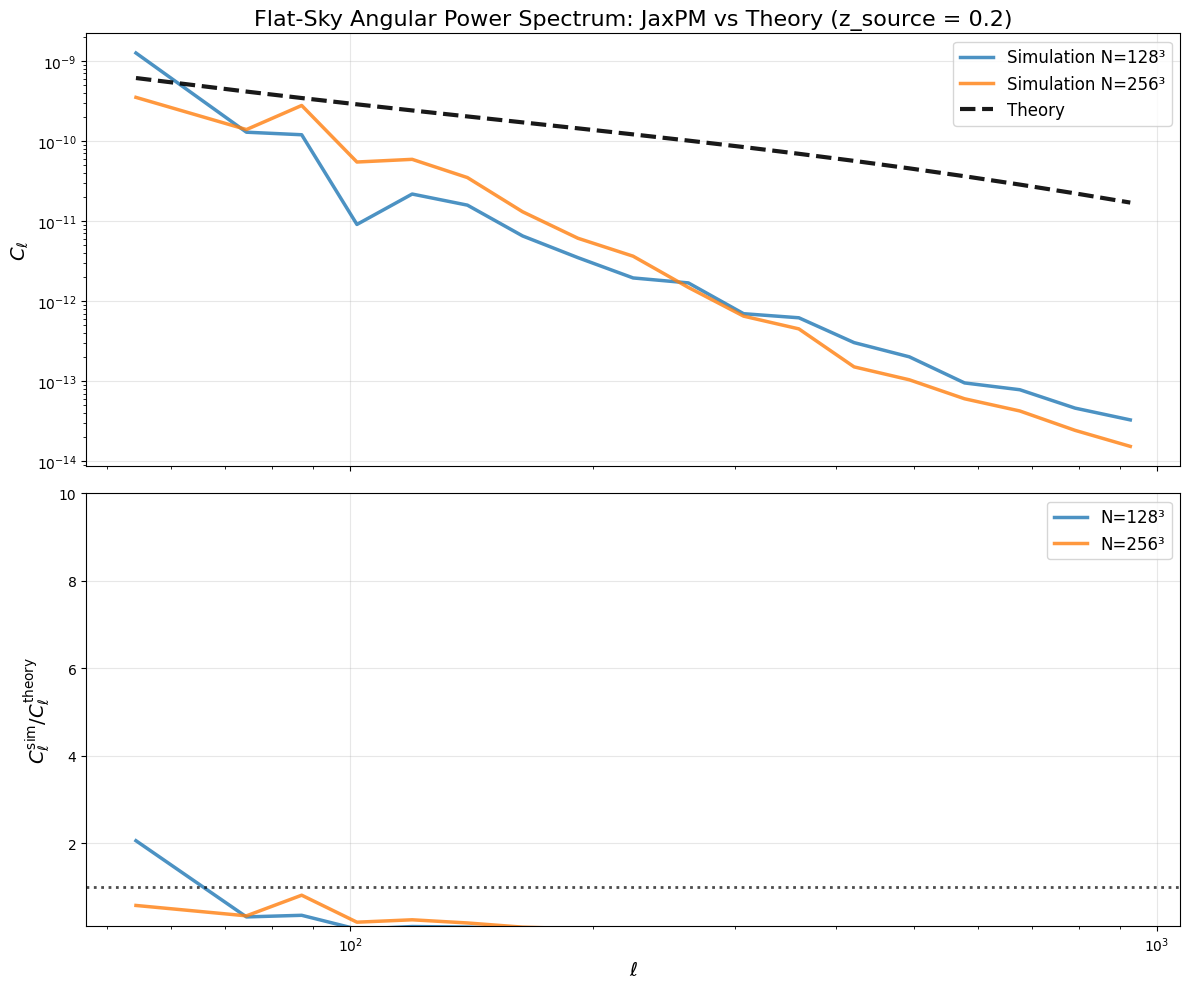


Flat-Sky Comparison Statistics:
------------------------------------------------------------
128Â³ mesh:
  Mean ratio (ell â‰¤ 192): 0.372
  Std ratio: 0.647
  Range: [0.024, 2.054]

256Â³ mesh:
  Mean ratio (ell â‰¤ 192): 0.305
  Std ratio: 0.245
  Range: [0.042, 0.807]

Flat-Sky Analysis Summary:
Field size: 9.6Â° Ã— 9.6Â°
Field resolution: 128 Ã— 128 pixels
Angular resolution: 4.5 arcmin/pixel

128Â³ mesh:
  Îº range: [-1.01e-03, 2.77e-03]
  Îº RMS: 6.70e-04
  Agreement with theory: 16.9%

256Â³ mesh:
  Îº range: [-9.26e-04, 2.35e-03]
  Îº RMS: 6.41e-04
  Agreement with theory: 13.9%

âœ“ Flat-sky angular power spectrum analysis complete using JaxPM!
Note: Power spectrum computed using jaxpm.utils.flat_sky_power_spectrum


In [11]:
## Main Result: Theory vs Simulation Comparison


def plot_theory_vs_simulation(results, z_source):
    """
    Create the main comparison plot: Theory vs Simulation with ratios.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

    # Top panel: Power spectra
    for i, (mesh_size, result) in enumerate(results.items()):
        color = colors[i % len(colors)]
        ell = result["ell"]
        cl_sim = result["cl_sim"]

        ax1.loglog(
            ell,
            cl_sim,
            color=color,
            linewidth=2.5,
            label=f"Simulation N={mesh_size}Â³",
            alpha=0.8,
        )

    # Add theory line
    first_result = list(results.values())[0]
    ax1.loglog(
        first_result["ell"],
        first_result["cl_theory"],
        "k--",
        linewidth=3,
        label="Theory",
        alpha=0.9,
    )

    ax1.set_ylabel(r"$C_\ell$", fontsize=14)
    ax1.set_title(
        f"Flat-Sky Angular Power Spectrum: JaxPM vs Theory (z_source = {z_source})",
        fontsize=16,
    )
    ax1.legend(fontsize=12, loc="upper right")
    ax1.grid(True, alpha=0.3)

    # Bottom panel: Ratios
    for i, (mesh_size, result) in enumerate(results.items()):
        color = colors[i % len(colors)]
        ell = result["ell"]
        cl_sim = result["cl_sim"]
        cl_theory = result["cl_theory"]

        ratio = cl_sim / cl_theory

        ax2.semilogx(
            ell, ratio, color=color, linewidth=2.5, label=f"N={mesh_size}Â³", alpha=0.8
        )

    # Add perfect agreement line
    ax2.axhline(1, color="black", linestyle=":", alpha=0.7, linewidth=2)

    ax2.set_xlabel(r"$\ell$", fontsize=14)
    ax2.set_ylabel(r"$C_\ell^{\mathrm{sim}} / C_\ell^{\mathrm{theory}}$", fontsize=14)
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0.1, 10)  # Reasonable range for ratios

    plt.tight_layout()
    plt.show()

    # Print comparison statistics
    print("\nFlat-Sky Comparison Statistics:")
    print("-" * 60)
    for mesh_size, result in results.items():
        ell = result["ell"]
        cl_sim = result["cl_sim"]
        cl_theory = result["cl_theory"]

        ratio = cl_sim / cl_theory

        # Focus on well-resolved modes (avoid very high ell)
        mask = ell <= min(200, max(ell) // 2)
        ratio_wellresolved = ratio[mask]

        print(f"{mesh_size}Â³ mesh:")
        print(
            f"  Mean ratio (ell â‰¤ {ell[mask][-1]:.0f}): {np.mean(ratio_wellresolved):.3f}"
        )
        print(f"  Std ratio: {np.std(ratio_wellresolved):.3f}")
        print(
            f"  Range: [{np.min(ratio_wellresolved):.3f}, {np.max(ratio_wellresolved):.3f}]"
        )
        print()


# Create the main comparison plot
plot_theory_vs_simulation(results, z_source)

# Additional flat-sky specific analysis
print("Flat-Sky Analysis Summary:")
print("=" * 50)
print(f"Field size: {field_size}Â° Ã— {field_size}Â°")
print(f"Field resolution: {field_npix} Ã— {field_npix} pixels")
print(f"Angular resolution: {field_size / field_npix * 60:.1f} arcmin/pixel")

for mesh_size, result in results.items():
    kappa = result["kappa"]
    ratio = result["cl_sim"] / result["cl_theory"]
    mean_ratio = np.mean(ratio)

    print(f"\n{mesh_size}Â³ mesh:")
    print(f"  Îº range: [{float(np.min(kappa)):.2e}, {float(np.max(kappa)):.2e}]")
    print(f"  Îº RMS: {float(np.sqrt(np.mean(kappa**2))):.2e}")
    print(f"  Agreement with theory: {mean_ratio:.1%}")

print(f"\nâœ“ Flat-sky angular power spectrum analysis complete using JaxPM!")
print(f"Note: Power spectrum computed using jaxpm.utils.flat_sky_power_spectrum")